In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import os

In [36]:
# Manually read and parse the file line by line to extract the structured data

def dataSize_packetLatency(application_name, y, cluster=3):
    # Define the directories to search
    base_dirs = [
        "./arxiv/adaptive",
        "./arxiv/minimal",
        "./arxiv/non-minimal",
        "./arxiv/prog-adaptive"
    ]
    
    # Initialize the figure for 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"{application_name} - Aggregate Packet Latency Under Different Routing Policies", fontsize=20)
    
    # Iterate over each directory and plot the data if the file exists
    for idx, base_dir in enumerate(base_dirs):
        file_path = os.path.join(base_dir, application_name, "dragonfly-msg-stats")
        if os.path.exists(file_path):
            # Extract the title for each plot
            parts = os.path.normpath(file_path).split(os.sep)
            title = f"{parts[-2]} ({parts[-3]})"
        
            # Process the file and prepare data
            data_list = []
            with open(file_path, 'r') as file:
                next(file)  # Skip header
                for line in file:
                    parts = line.split()
                    if len(parts) == 7:
                        data_list.append([int(parts[0]), int(parts[1]), int(parts[2]), float(parts[3]),
                                          int(parts[4]), float(parts[5]), float(parts[6])])
            
            # Create DataFrame and filter out rows with zero Total_Data_Size
            data_df = pd.DataFrame(data_list, columns=["LP_id", "Terminal_ID", "Total_Data_Size", 
                                                       "Aggregate_Packet_Latency", "Num_Flits_Packets_Finished", 
                                                       "Avg_Hops", "Busy_Time"])
            data_filtered_df = data_df[data_df["Total_Data_Size"] > 0].copy()
            
            # Clustering based on Total Data Size only
            X = data_filtered_df[["Total_Data_Size"]].values
            kmeans = KMeans(n_clusters=cluster, random_state=42)
            data_filtered_df["Cluster"] = kmeans.fit_predict(X)
            
            # Determine the min and max Total Data Size for each cluster
            cluster_ranges = data_filtered_df.groupby("Cluster")["Total_Data_Size"].agg(["min", "max"]).reset_index()
            
            # Sort clusters by the minimum data size to ensure smallest cluster number for smallest data
            cluster_ranges = cluster_ranges.sort_values("min").reset_index(drop=True)
            cluster_ranges["New_Cluster"] = cluster_ranges.index  # Assign new cluster numbers based on order

            # Map old cluster numbers to new ones
            cluster_map = dict(zip(cluster_ranges["Cluster"], cluster_ranges["New_Cluster"]))
            interval_map = dict(zip(cluster_ranges["New_Cluster"], 
                                    cluster_ranges.apply(lambda row: f"{int(row['min'])}-{int(row['max'])}", axis=1)))
            
            # Apply the new cluster labels to the data
            data_filtered_df["Cluster"] = data_filtered_df["Cluster"].map(cluster_map).astype(str)
            
            # Ensure clusters on x-axis are sorted starting from 0
            data_filtered_df["Cluster"] = pd.Categorical(data_filtered_df["Cluster"], ordered=True, categories=sorted(data_filtered_df["Cluster"].unique()))

            # Plot in the appropriate subplot
            ax = axes[idx // 2, idx % 2]
            sns.violinplot(x="Cluster", y="Aggregate_Packet_Latency", data=data_filtered_df, order=sorted(data_filtered_df["Cluster"].unique()), ax=ax)
            ax.set_title(title, fontsize=16)
            ax.set_xlabel("Cluster Number", fontsize=14)
            ax.set_ylabel("Aggregate Packet Latency (ns)", fontsize=14)
            ax.set_ylim(0, y)
            ax.grid(axis='y')
            
            # Convert data size intervals to MB in the interval_map
            interval_map = dict(zip(cluster_ranges["New_Cluster"], 
                                    cluster_ranges.apply(lambda row: f"{row['min'] / 1e6:.2f}-{row['max'] / 1e6:.2f} MB", axis=1)))
            
            # Add a legend to indicate data size intervals for each cluster in MB
            handles = [plt.Line2D([0], [0], marker='o', color='w', label=f"Cluster {i}: {interval_map[i]}",
                                  markerfacecolor='black', markersize=8) for i in range(cluster)]
            ax.legend(handles=handles, title="Data Size Interval (MB)", title_fontsize='13', fontsize='11')
    
    # Adjust layout for better spacing between subplots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show(

SyntaxError: incomplete input (3085882019.py, line 83)

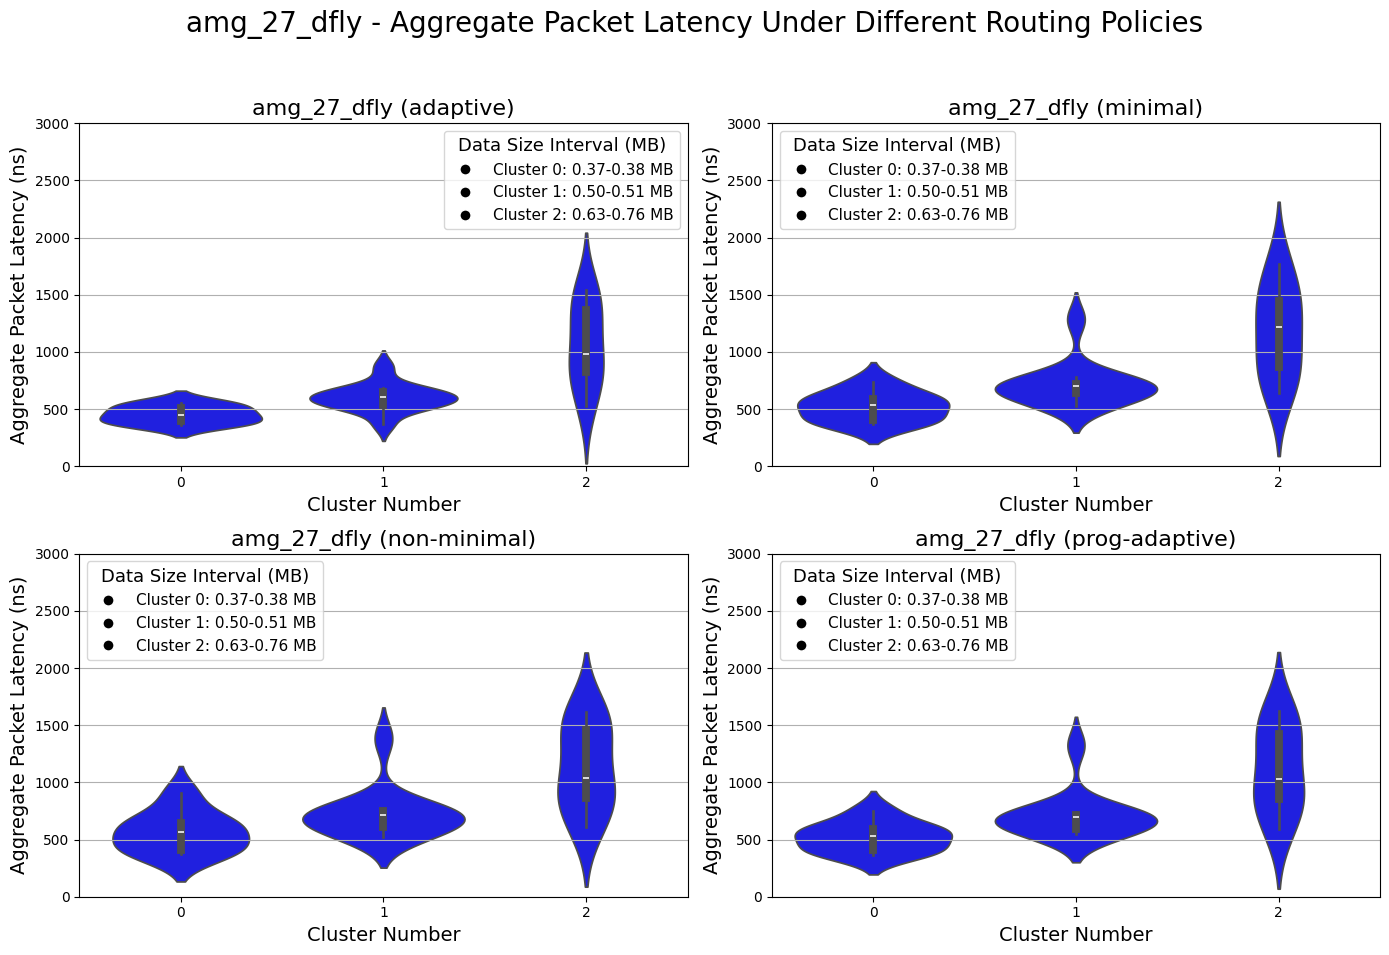

In [35]:
dataSize_packetLatency("amg_27_dfly",3000)

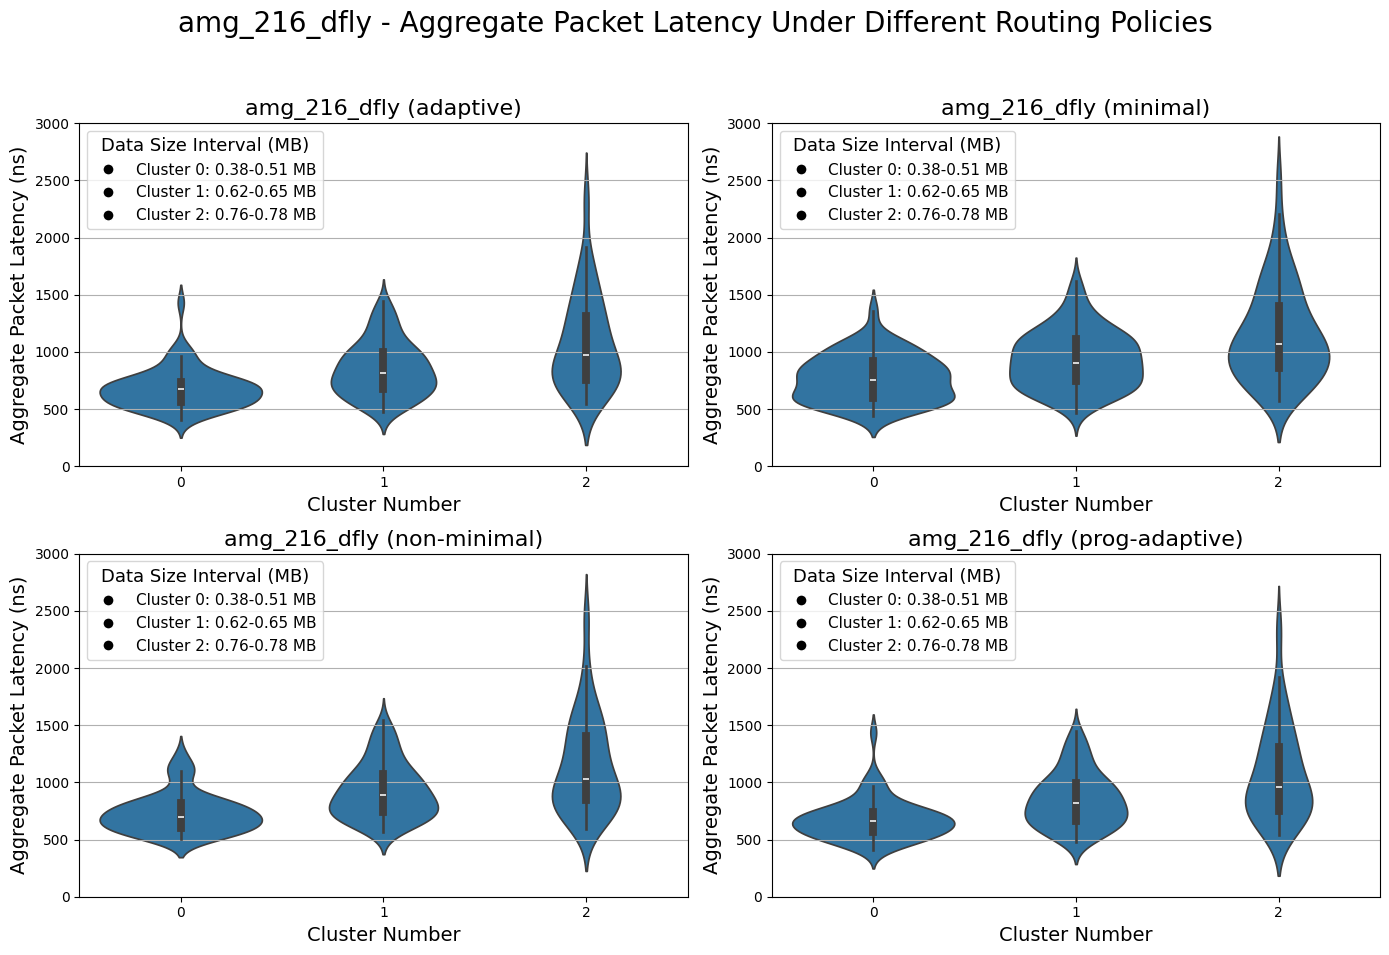

In [29]:
dataSize_packetLatency("amg_216_dfly",3000)

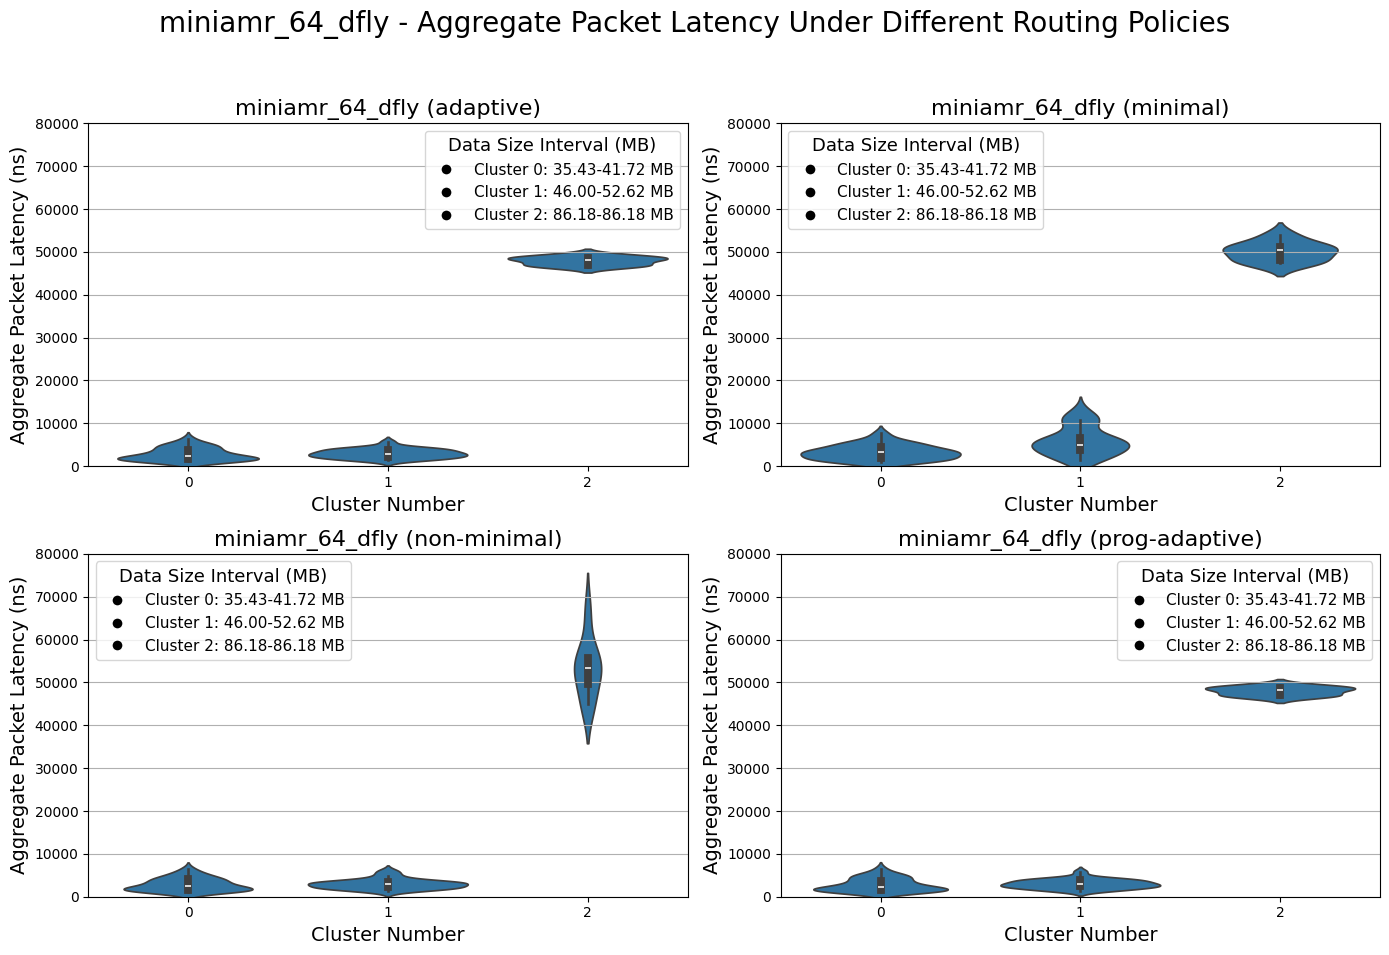

In [30]:
 dataSize_packetLatency("miniamr_64_dfly",80000,3)

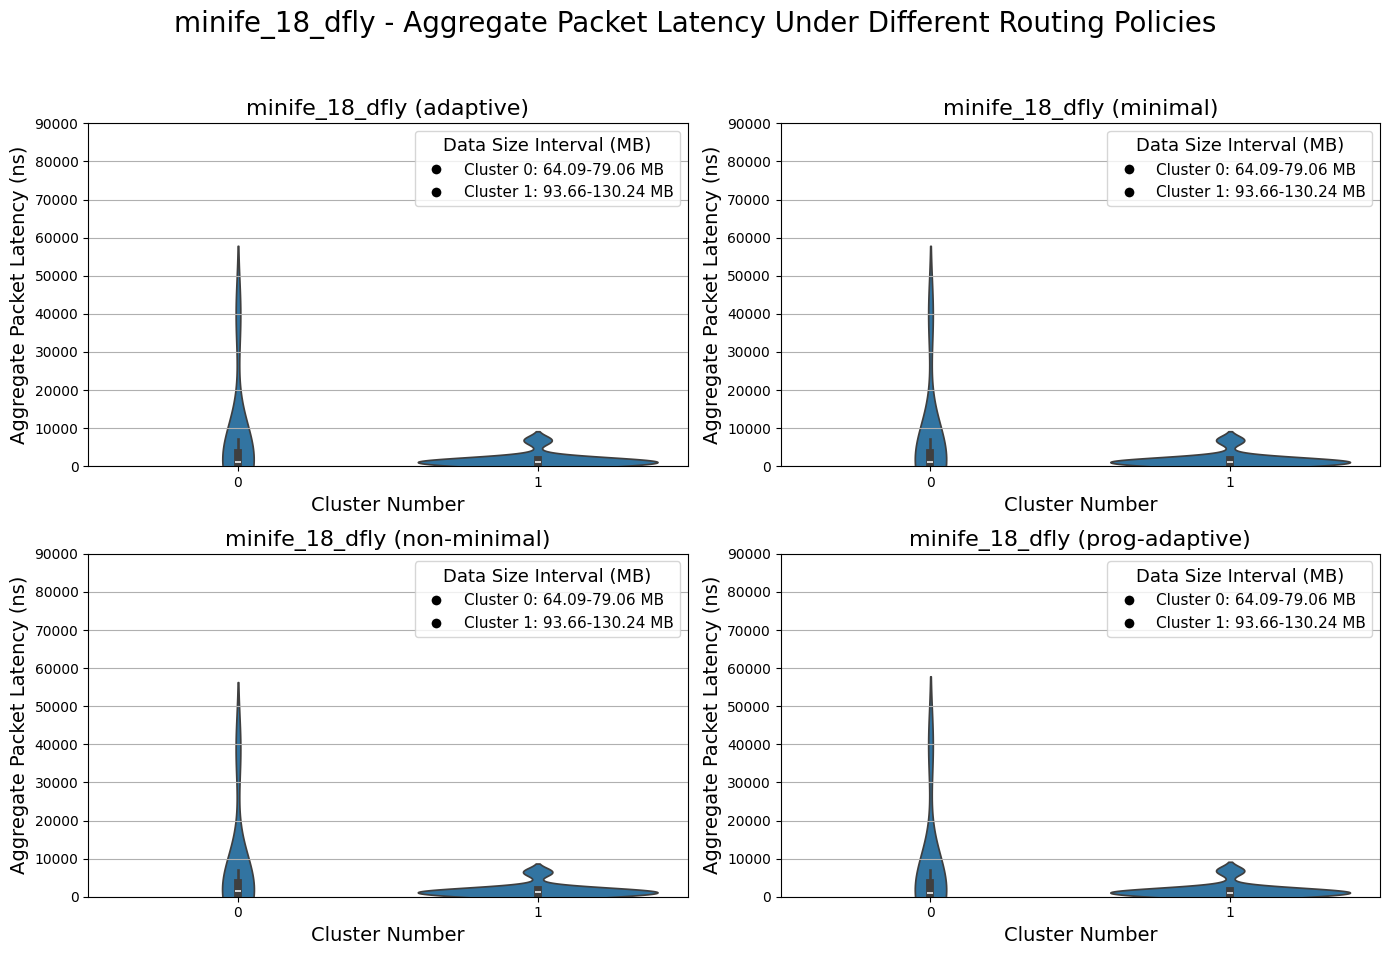

In [31]:
dataSize_packetLatency("minife_18_dfly",90000,2)

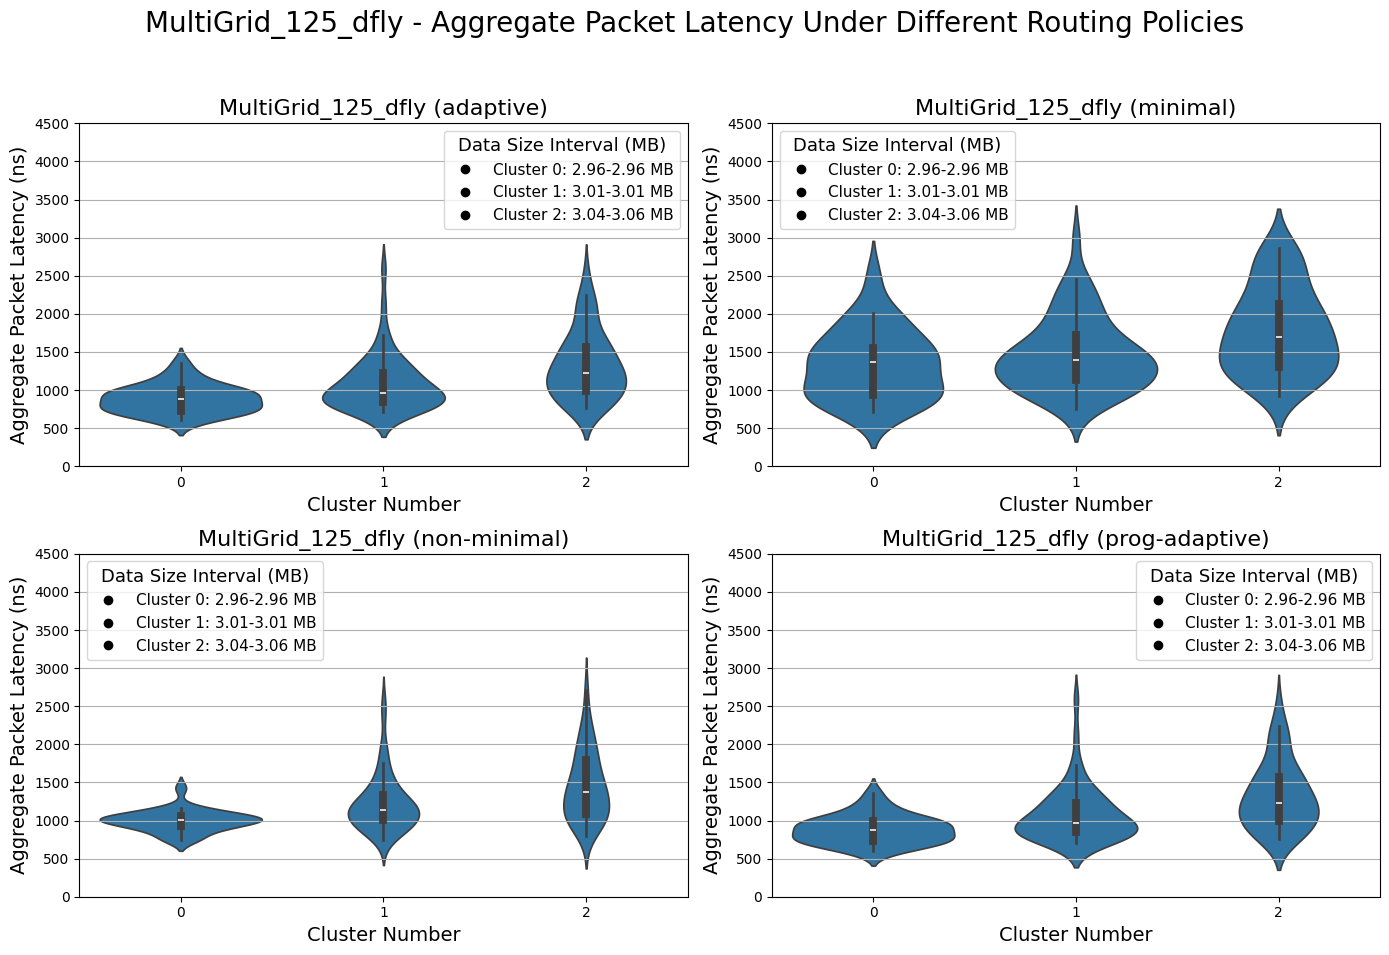

In [33]:
dataSize_packetLatency("MultiGrid_125_dfly",4500)

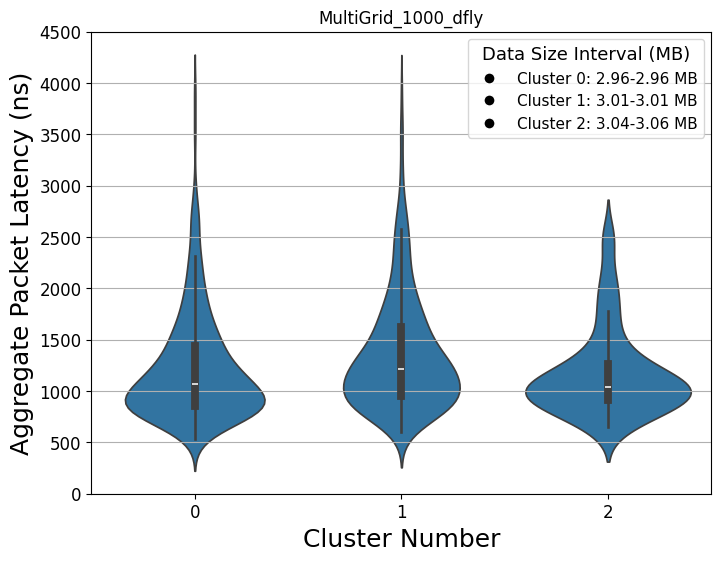

In [140]:
dataSize_packetLatency("./arxiv/MultiGrid_1000_dfly/dragonfly-msg-stats",4500)

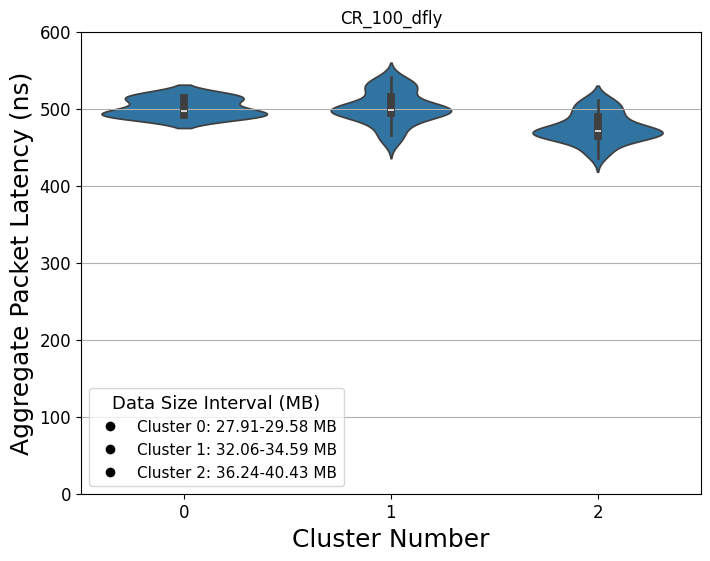

In [5]:
dataSize_packetLatency("./arxiv/CR_100_dfly//dragonfly-msg-stats",600)